# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [53]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/medz1966/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

fatal: destination path 'exam_2025_session2' already exists and is not an empty directory.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


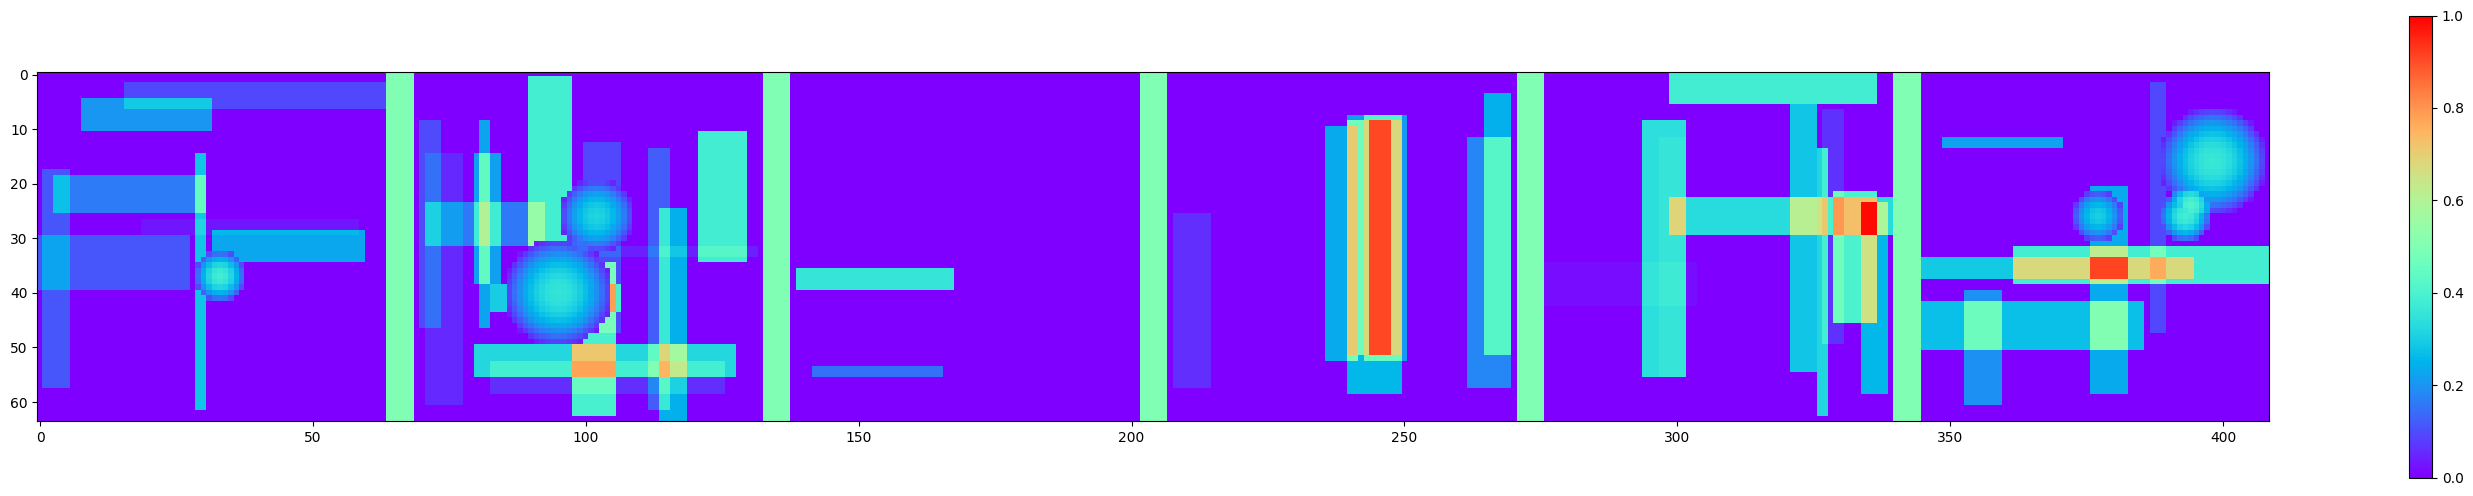

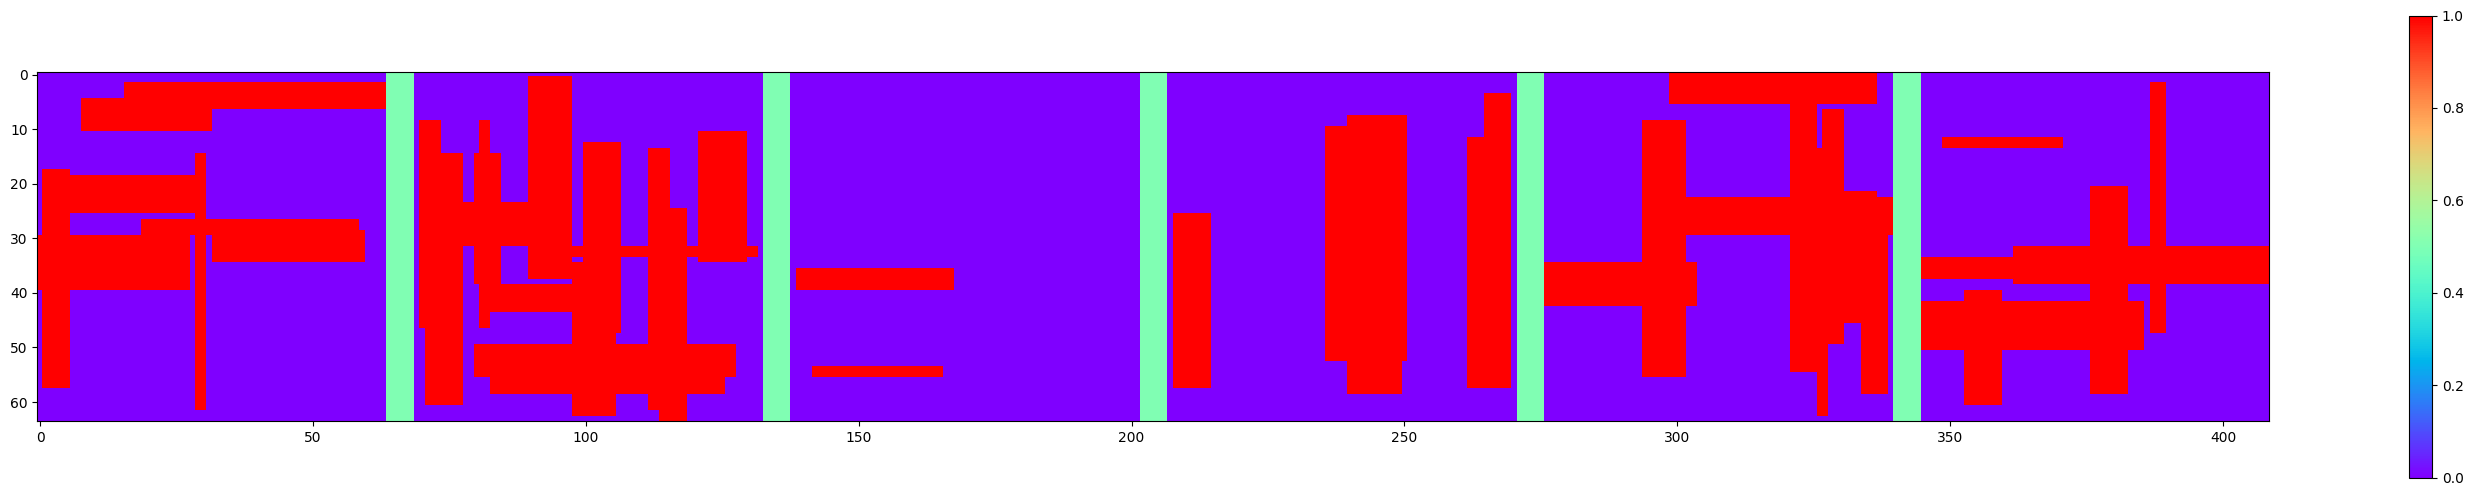

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

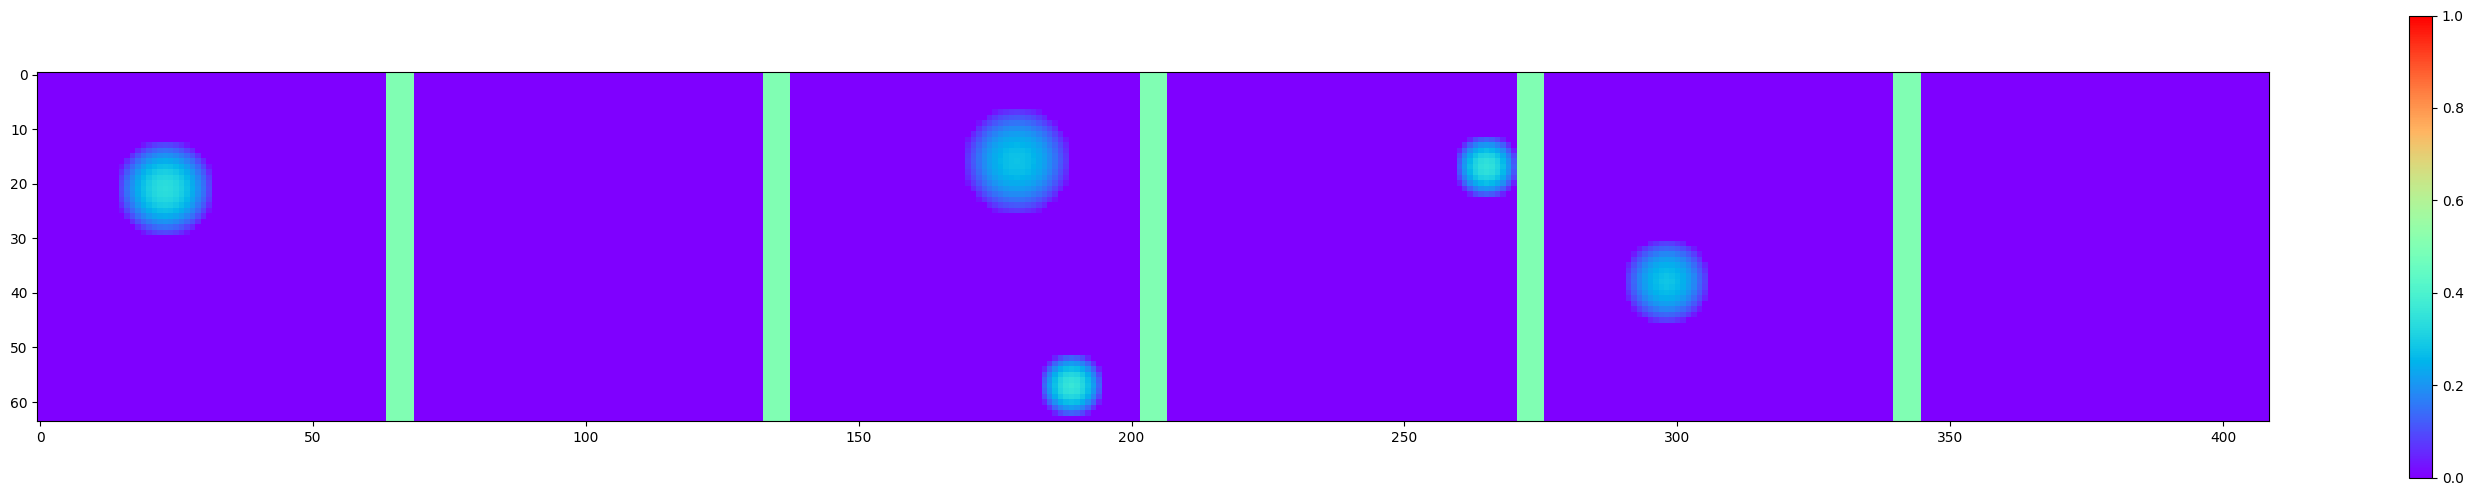

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

Supervision faible (ou apprentissage faiblement supervisé) fait référence à des situations où les données d'entraînement ne sont pas parfaitement annotées ou où les annotations sont incomplètes, imprécises ou bruitées. Contrairement à la supervision forte, où chaque exemple d'entraînement est accompagné d'une étiquette précise et détaillée, la supervision faible repose sur des informations partielles ou indirectes pour guider l'apprentissage.

Dans ce problème, la supervision faible s'applique car :

Les images générées par gen_dr contiennent à la fois des disques (considérés comme du bruit) et des rectangles (les objets d'intérêt).

La cible idéale (ideal_targets) est fournie, mais en pratique, elle n'est pas disponible. Cela signifie que l'on dispose d'une forme de supervision (les cibles idéales), mais elle est limitée ou inaccessible dans un scénario réel.

L'objectif est de segmenter les pixels affectés par les rectangles avant corruption, ce qui nécessite de distinguer les rectangles des disques (bruit) sans avoir accès à des annotations parfaites pour chaque pixel.

Ainsi, ce problème entre dans la catégorie de la supervision faible car il repose sur des informations partielles (les cibles idéales) pour entraîner un modèle à segmenter les rectangles dans un contexte où le bruit (disques) est présent.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

Le modèle identifie bien la forme générale des rectangles, mais les transitions restent floues, avec des bords imprécis et quelques faux positifs aux zones de recouvrement avec les disques. Malgré ces artefacts, le UNet parvient à apprendre la structure principale. Des améliorations pourraient inclure un ajustement de l’architecture ou une meilleure régularisation pour affiner les contours et réduire les confusions dans les zones bruitées.

<ipython-input-42-c86bb2a11a41>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)
<ipython-input-42-c86bb2a11a41>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).squeeze(2)


Époque 0/50, Perte : 0.7245
Époque 10/50, Perte : 0.1884
Époque 20/50, Perte : 0.1283
Époque 30/50, Perte : 0.0920
Époque 40/50, Perte : 0.0678


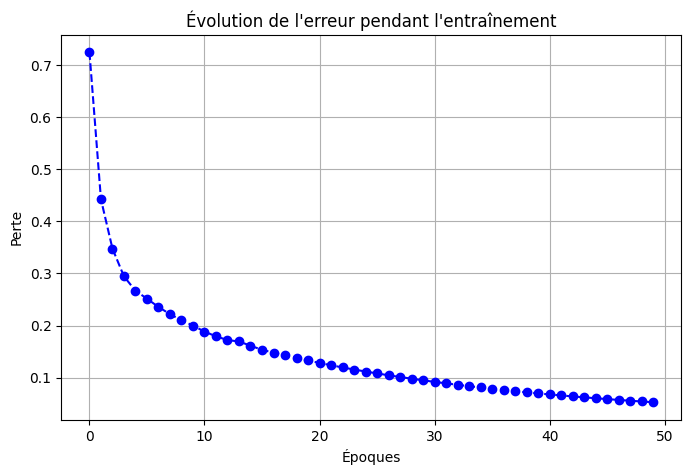

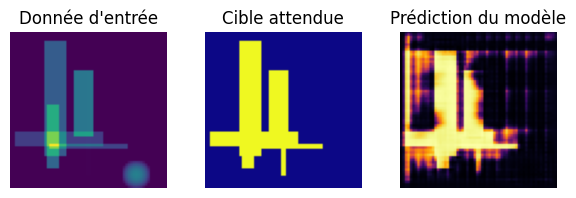

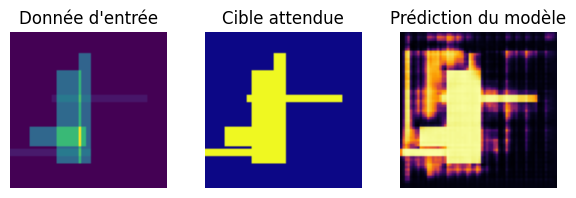

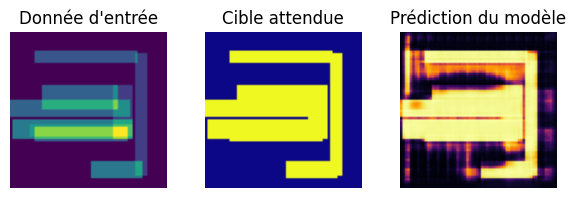

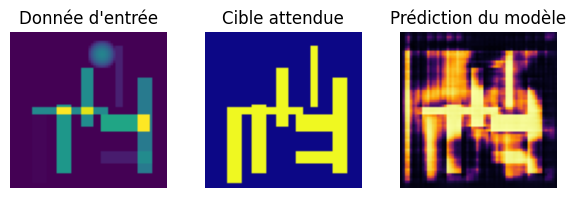

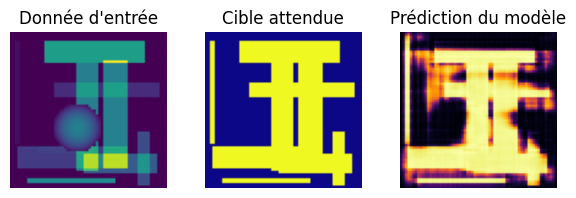

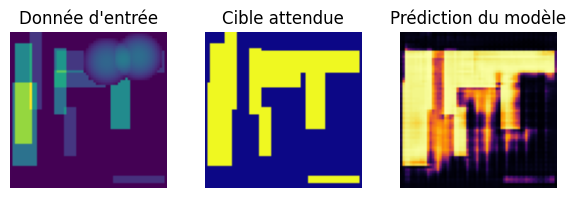

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import gen_dr, UNet  # Import des fonctions nécessaires

def train_segmentation_model(n_epochs=50, batch_size=6, lr=0.001):
    """
    Entraînement d'un modèle UNet pour la segmentation avec un dataset synthétique.
    """

    # Génération des données d'entraînement
    inputs, labels = gen_dr(batch_size)

    # Conversion en tenseurs PyTorch
    inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1).squeeze(2)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).squeeze(2)

    # Initialisation du modèle UNet
    model = UNet(n_channels=1, n_classes=1)

    # Définition de la fonction de perte et de l'optimiseur
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    # Boucle d'entraînement
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 10 == 0:
            print(f"Époque {epoch}/{n_epochs}, Perte : {loss.item():.4f}")

    # Affichage de la convergence de la perte
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, linestyle="--", marker="o", color="b")
    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.title("Évolution de l'erreur pendant l'entraînement")
    plt.grid(True)
    plt.show()

    # Mode évaluation
    model.eval()
    with torch.no_grad():
        predictions = torch.sigmoid(model(inputs)).numpy()

    # Visualisation des résultats
    for i in range(batch_size):
        plt.figure(figsize=(6, 2))

        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i, 0], cmap="viridis")
        plt.title("Donnée d'entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i, 0], cmap="plasma")
        plt.title("Cible attendue")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i, 0], cmap="inferno")
        plt.title("Prédiction du modèle")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return model

# Lancement de l'entraînement
segmentation_model = train_segmentation_model()


\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([5.9047, 2.4036, 3.2645, 7.3407, 4.5212, 2.0014])


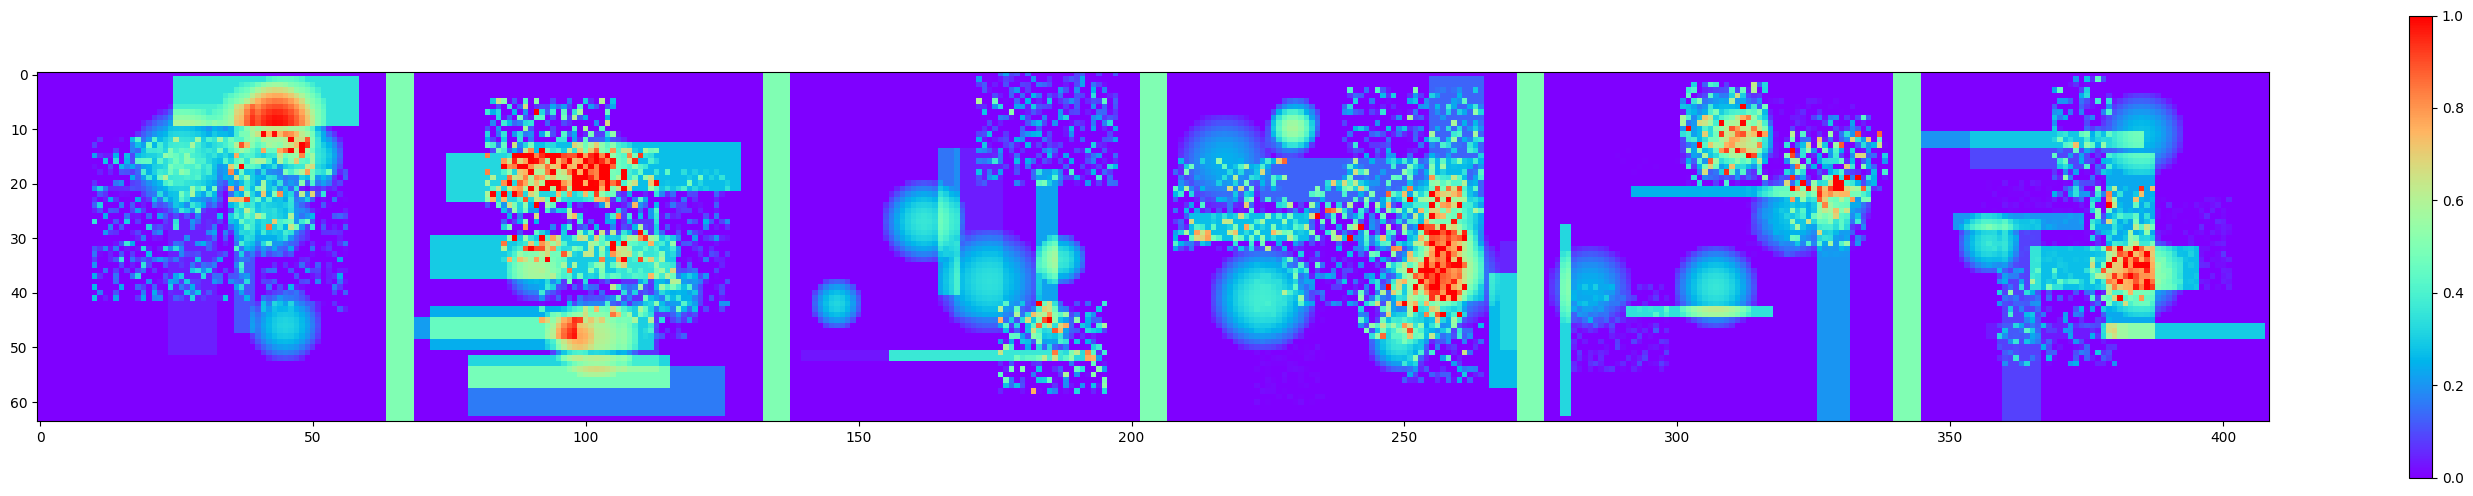

tensor([6.1270, 1.8286, 2.2591, 7.2719, 5.3125, 1.9292])


In [43]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

Q1 Définir un Loader à partir du Dataset précédent (2 workers)

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
from utils import gen_ex2, voir_batch2D  # Import des fonctions nécessaires

class CustomDataset(Dataset):
    """Dataset personnalisé qui génère des données via gen_ex2()."""

    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        inputs, targets = gen_ex2(1)  # Générer un seul échantillon
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Paramètres
batch_size = 6
num_workers = 2

# Création du DataLoader
dataset = CustomDataset(num_samples=100)  # 100 exemples pour l'entraînement
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)



**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import io
import contextlib
from utils import gen_ex2  # function provided in utils.py to generate (input, target)

# ---------------------------
# 1. Define the Custom Dataset
# ---------------------------
class CustomDataset(Dataset):
    """
    Dataset qui génère des exemples à la volée via gen_ex2.
    Chaque appel de __getitem__ génère une image et sa cible associée.
    """
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Suppress output from gen_ex2
        with contextlib.redirect_stdout(io.StringIO()):
            inputs, targets = gen_ex2(1)
        # inputs: (1, 1, 64, 64) et targets: (1,)
        return inputs[0], targets[0] / 100.0

# Créer le DataLoader avec 2 workers
batch_size = 16
dataset = CustomDataset(num_samples=1000)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# ---------------------------
# 2. Construire et adapter ResNet18
# ---------------------------
# Charger un modèle ResNet18 non pré-entraîné
model = models.resnet18(pretrained=False)

# Adapter la première couche pour accepter 1 canal au lieu de 3
old_conv = model.conv1  # forme: (64, 3, 7, 7)
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)
# Copier les poids du premier canal (optionnel)
with torch.no_grad():
    new_conv.weight.copy_(old_conv.weight[:, :1])
model.conv1 = new_conv

# Adapter la couche fully-connected finale pour produire une sortie scalaire
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, 1)

# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------------------------
# 3. Définir la fonction de perte et l'optimiseur
# ---------------------------
# On utilise la perte L1 (équivalente à la pinball loss pour τ=0.5)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------
# 4. Boucle d'entraînement
# ---------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device)               # (batch_size, 1, 64, 64)
        y = y.to(device).unsqueeze(1)    # (batch_size,) -> (batch_size, 1)

        optimizer.zero_grad()
        y_pred = model(x)              # Prédiction du modèle (batch_size, 1)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

# ---------------------------
# 5. Remarque sur l'absence de validation
# ---------------------------
# Ici, la validation n'est pas nécessaire car les données sont générées à la volée
# selon une loi connue et contrôlée (pas de distribution shift). Ainsi, il n'y a
# pas de risque d'overfitting typique d'un jeu de données statique, ce qui rend
# l'étape de validation moins pertinente pour cet exercice.


Epoch 1/10 - Loss: 0.2120
Epoch 2/10 - Loss: 0.1027
Epoch 3/10 - Loss: 0.0753
Epoch 4/10 - Loss: 0.0784
Epoch 5/10 - Loss: 0.0499
Epoch 6/10 - Loss: 0.0609
Epoch 7/10 - Loss: 0.0411
Epoch 8/10 - Loss: 0.0446
Epoch 9/10 - Loss: 0.0641
Epoch 10/10 - Loss: 0.0419


L'absence d'une phase de validation dans cet entraînement peut être justifiée par plusieurs raisons :

**Données synthétiques générées dynamiquement**

La fonction gen_ex2(n) génère des données à la volée, ce qui signifie que chaque batch est différent mais suit la même distribution.
Par conséquent, les données de validation ne seraient pas fondamentalement différentes des données d'entraînement.
Si la distribution ne change pas, la validation ne donne pas d’information supplémentaire.


**Optimisation directe de la médiane conditionnelle**

On entraîne le modèle pour approximer la médiane conditionnelle.
Contrairement à une tâche de classification où un surajustement peut être détecté via la validation, ici la médiane est robuste et moins affectée par le bruit ou les outliers.
Si le modèle apprend bien sur les données d'entraînement, il généralisera naturellement sur des données similaires.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [68]:
import io
import contextlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from utils import gen_ex2

# ---------------------------
# 1. Define the Custom Dataset
# ---------------------------
class CustomDataset(Dataset):
    """
    Dataset qui génère des exemples à la volée via gen_ex2.
    Chaque appel de __getitem__ génère une image et sa cible associée.
    """
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Suppress output from gen_ex2
        with contextlib.redirect_stdout(io.StringIO()):
            inputs, targets = gen_ex2(1)
        # Normalize target by dividing by 100 (if targets are around 100)
        return inputs[0], targets[0] / 100.0

# Créer le DataLoader avec 2 workers
batch_size = 16
dataset = CustomDataset(num_samples=1000)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# ---------------------------
# 2. Construire et adapter ResNet18
# ---------------------------
# Charger un modèle ResNet18 non pré-entraîné
model = models.resnet18(pretrained=False)

# Adapter la première couche pour accepter 1 canal au lieu de 3
old_conv = model.conv1  # forme: (64, 3, 7, 7)
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)
# Copier les poids du premier canal (optionnel)
with torch.no_grad():
    new_conv.weight.copy_(old_conv.weight[:, :1])
model.conv1 = new_conv

# Modifier la couche fully-connected finale pour produire 3 sorties
# correspondant aux premier (25%), médian (50%) et troisième (75%) quartiles.
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, 3)

# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------------------------
# 3. Définir la fonction de coût : la Quantile Loss (Pinball Loss)
# ---------------------------
def quantile_loss(preds, target, quantiles=torch.tensor([0.25, 0.5, 0.75], device='cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Calcule la perte quantile (pinball loss) pour chaque quantile et retourne la moyenne.
    preds: tenseur de forme (batch_size, 3)
    target: tenseur de forme (batch_size,) ou (batch_size,1)
    quantiles: tenseur des quantiles, ici [0.25, 0.5, 0.75]
    """
    # S'assurer que target est de la forme (batch_size, 1)
    if target.dim() == 1:
        target = target.unsqueeze(1)
    # Différence entre la cible et la prédiction
    diff = target - preds  # shape: (batch_size, 3)
    # Redimensionner quantiles pour le broadcasting
    q = quantiles.unsqueeze(0)  # shape: (1, 3)
    # Calculer la perte pour chaque quantile
    loss = torch.where(diff >= 0, q * diff, (q - 1) * diff)
    return torch.mean(loss)

# ---------------------------
# 4. Définir l'optimiseur
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------
# 5. Boucle d'entraînement
# ---------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device)               # (batch_size, 1, 64, 64)
        y = y.to(device)               # (batch_size,) ou (batch_size,1)

        optimizer.zero_grad()
        y_pred = model(x)              # (batch_size, 3) : prédictions pour 25%, 50% et 75%
        loss = quantile_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")



Epoch 1/10 - Loss: 0.0714
Epoch 2/10 - Loss: 0.0386
Epoch 3/10 - Loss: 0.0380
Epoch 4/10 - Loss: 0.0470
Epoch 5/10 - Loss: 0.0300
Epoch 6/10 - Loss: 0.0257
Epoch 7/10 - Loss: 0.0183
Epoch 8/10 - Loss: 0.0204
Epoch 9/10 - Loss: 0.0188
Epoch 10/10 - Loss: 0.0183


**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

Mean IQR: 0.31583064794540405
Std IQR: 0.012725490145385265


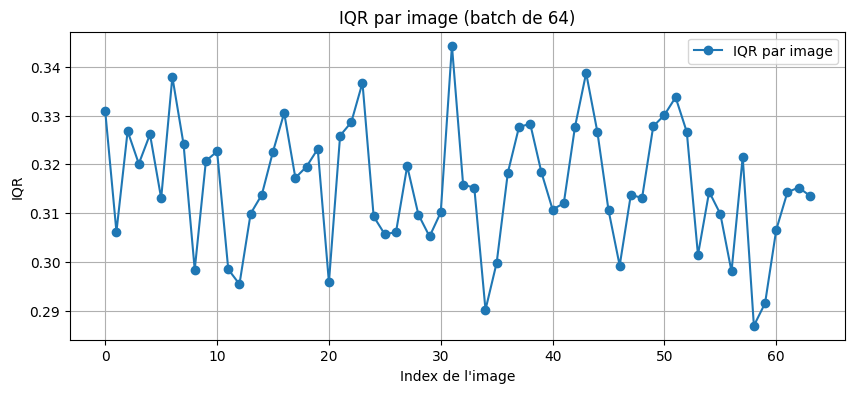

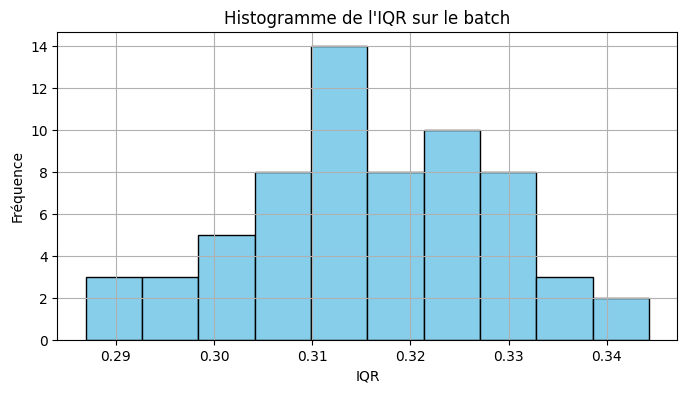

In [75]:
import numpy as np
import torch

# Evaluation: compute IQR on a batch of 64 images
model.eval()  # set the model in evaluation mode
batch_size_eval = 64

# Build a batch of 64 images from your dataset
inputs_list = []
for i in range(batch_size_eval):
    inp, _ = dataset[i]  # We don't need the target here
    inputs_list.append(inp)
inputs_eval = torch.stack(inputs_list).to(device)

with torch.no_grad():
    preds = model(inputs_eval)  # preds shape: (64, 3) with [q25, q50, q75]
    q25 = preds[:, 0]
    q50 = preds[:, 1]
    q75 = preds[:, 2]
    iqr = q75 - q25  # Compute interquartile range for each image

# Display the IQR for each image, as well as their mean and standard deviation
#print("Interquartile Ranges (IQR) per image:")
#print(iqr.cpu().numpy())
print("Mean IQR:", iqr.mean().item())
print("Std IQR:", iqr.std().item())

# Convert IQR to numpy for plotting
iqr_np = iqr.cpu().numpy()

# Plot 1: IQR values per image index
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(iqr_np)), iqr_np, 'o-', label='IQR par image')
plt.xlabel("Index de l'image")
plt.ylabel("IQR")
plt.title("IQR par image (batch de 64)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Histogram of IQR values
plt.figure(figsize=(8, 4))
plt.hist(iqr_np, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("IQR")
plt.ylabel("Fréquence")
plt.title("Histogramme de l'IQR sur le batch")
plt.grid(True)
plt.show()#


Les plots montrent que l'IQR (écart interquartile) prédit par le modèle est presque constant d'une image à l'autre. Le graphe en fonction de l'indice d'image révèle peu de variation (moyenne ≈ 0.316 et écart-type ≈ 0.012), et l'histogramme confirme que la distribution des IQR est très concentrée autour de cette valeur. Cela suggère que le modèle estime une incertitude homogène (homoscédastique) pour toutes les images, c'est-à-dire que l'écart interquartile ne dépend pas significativement des caractéristiques de l'image d'entrée.

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.



L'**adaptation de domaine** (*domain adaptation*) vise à entraîner un modèle sur un domaine source (train) tout en généralisant à un domaine cible (test) ayant une distribution différente. Elle est utilisée lorsque les données d’entraînement ne sont pas représentatives des données d’inférence.  

**Lien avec l'énoncé** :
- `gen_dr_train` et `gen_dr_test` produisent des distributions différentes (test plus chargé en figures).
- Le modèle doit apprendre à nettoyer les images malgré cet écart statistique.
- Cas fréquent en apprentissage machine où les données d’entraînement sont abondantes mais différentes des données réelles d’inférence.
- L’adaptation de domaine permet d’améliorer la généralisation en réduisant cet écart.


**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

Training on ideal data (gen_dr)...
Epoch 0/40 - Loss: 0.7131
Epoch 5/40 - Loss: 0.2726
Epoch 10/40 - Loss: 0.2049
Epoch 15/40 - Loss: 0.1602
Epoch 20/40 - Loss: 0.1343
Epoch 25/40 - Loss: 0.1139
Epoch 30/40 - Loss: 0.0970
Epoch 35/40 - Loss: 0.0832

Training on domain-adapted data (gen_dr_train)...
Epoch 0/40 - Loss: 0.8201
Epoch 5/40 - Loss: 0.6079
Epoch 10/40 - Loss: 0.5120
Epoch 15/40 - Loss: 0.4390
Epoch 20/40 - Loss: 0.3863
Epoch 25/40 - Loss: 0.3458
Epoch 30/40 - Loss: 0.3153
Epoch 35/40 - Loss: 0.2926

Test Loss Comparison:
  Ideal Training (gen_dr): 1.6577
  Domain Adaptation Training (gen_dr_train): 0.3197


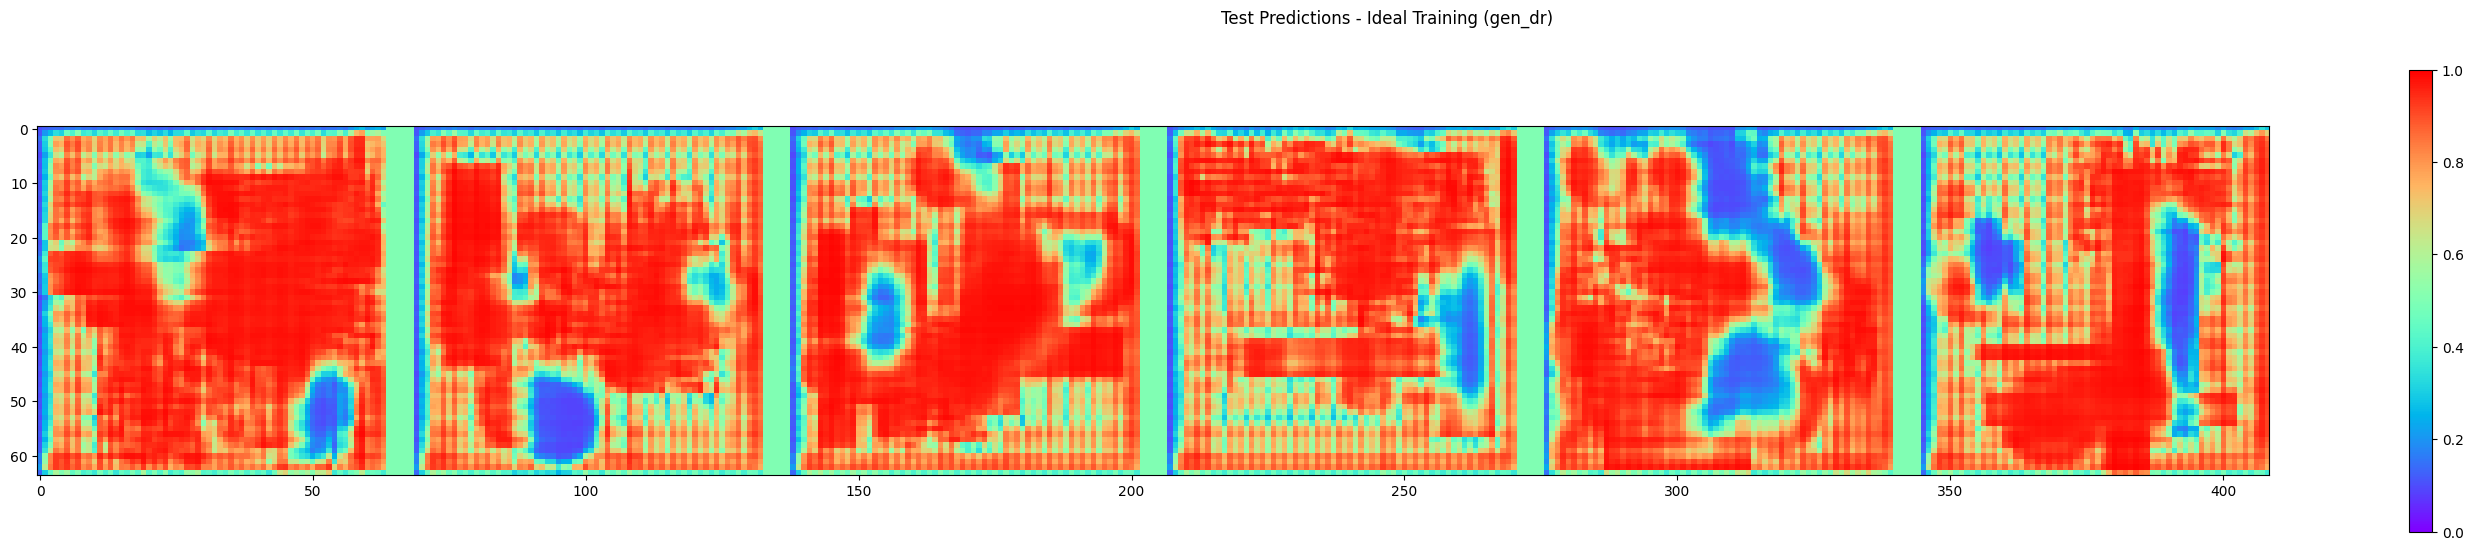

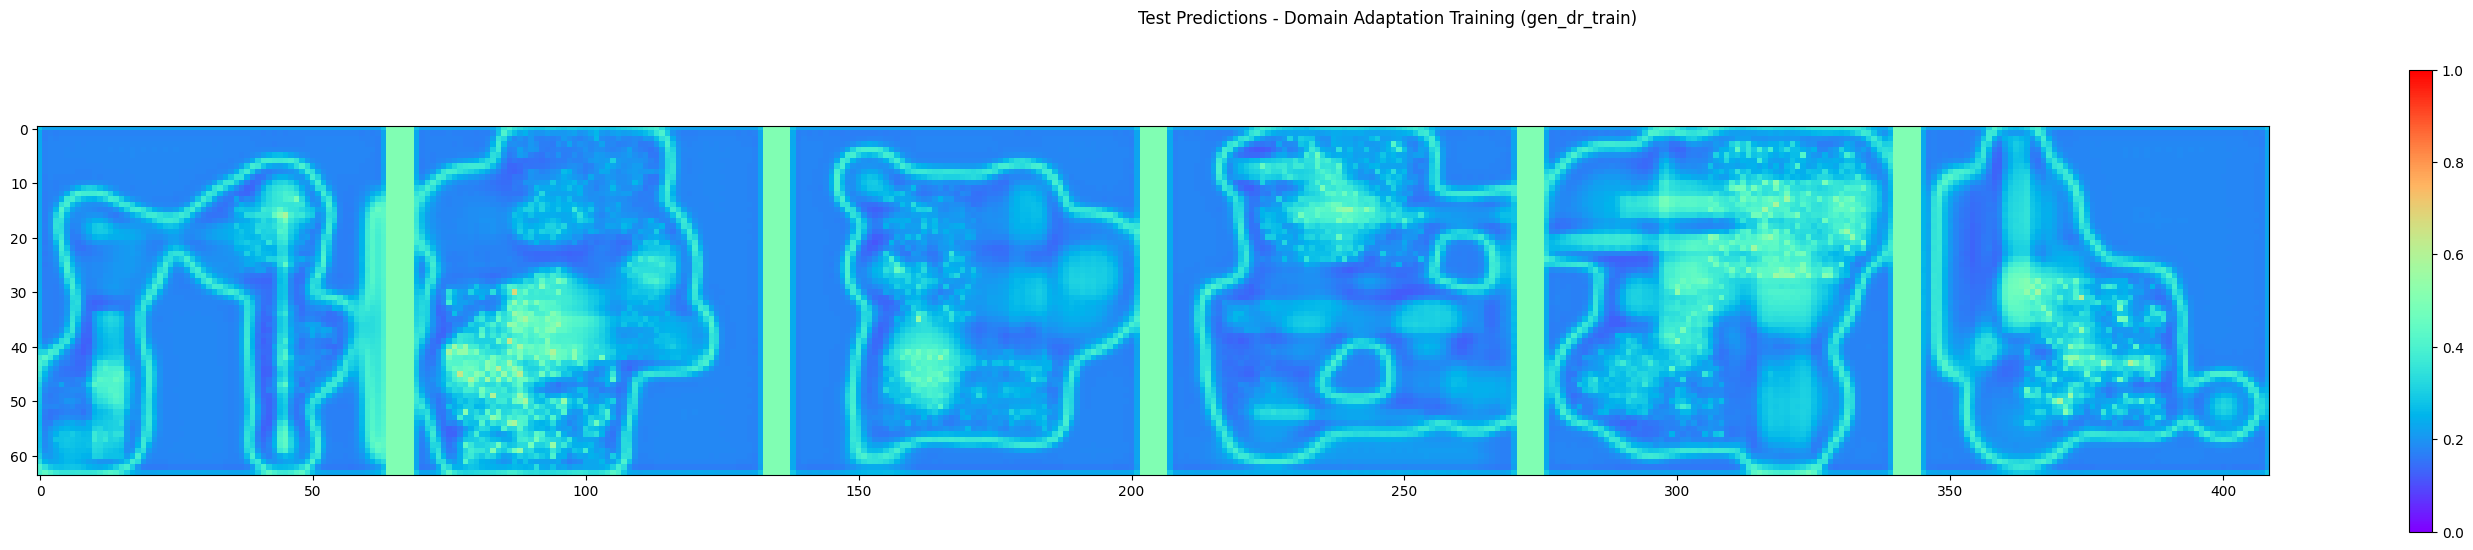

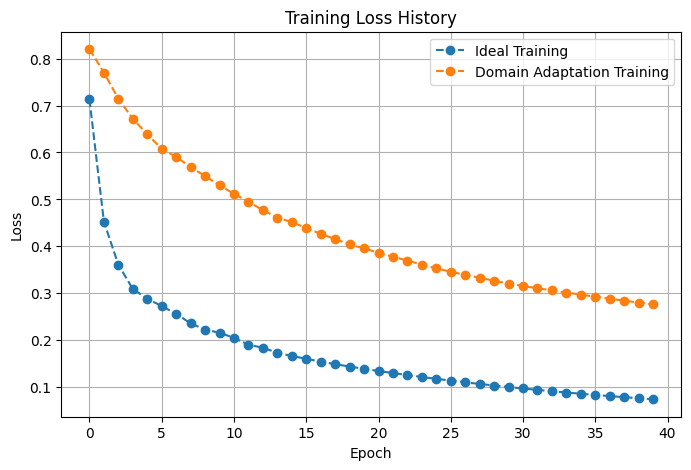

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Import the necessary functions and classes from utils.
# These include:
#   - gen_dr: generates ideal training data (inputs = target + trivial noise)
#   - gen_dr_train: generates training data from a shifted distribution
#   - gen_dr_test: generates test data with more geometric figures
#   - UNet: the segmentation model architecture
#   - voir_batch2D: function to visualize a batch of images
from utils import gen_dr, gen_dr_train, gen_dr_test, UNet, voir_batch2D

def train_model(generator_func, n_epochs=40, batch_size=6, lr=0.001):
    """
    Trains a UNet model using data generated by the specified generator function.

    Parameters:
      generator_func: function used to generate (inputs, targets)
      n_epochs: number of training epochs
      batch_size: size of the batch (number of images)
      lr: learning rate

    Returns:
      model: the trained UNet model
      loss_history: list of loss values per epoch
    """
    # Generate training data
    inputs, targets = generator_func(batch_size)
    inputs = inputs.float()
    targets = targets.float()  # Convert boolean targets to float

    # Note: inputs and targets are already torch tensors of shape [batch_size, 1, 64, 64]

    # Initialize the UNet model
    model = UNet(n_channels=1, n_classes=1)

    # Define the loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{n_epochs} - Loss: {loss.item():.4f}")

    return model, loss_history

def evaluate_model(model, generator_func, batch_size=6):
    """
    Evaluates the given model on data from the provided generator function.

    Returns:
      predictions: model predictions (after sigmoid)
      test_loss: loss computed on the test batch
    """
    inputs, targets = generator_func(batch_size)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)

    criterion = nn.BCEWithLogitsLoss()
    test_loss = criterion(outputs, targets).item()
    return predictions, test_loss

# -------------------------------------------------------------------
# Train on ideal training data (using gen_dr)
print("Training on ideal data (gen_dr)...")
model_ideal, loss_history_ideal = train_model(gen_dr, n_epochs=40, batch_size=6, lr=0.001)

# Train on domain-adapted data (using gen_dr_train)
print("\nTraining on domain-adapted data (gen_dr_train)...")
model_da, loss_history_da = train_model(gen_dr_train, n_epochs=40, batch_size=6, lr=0.001)

# -------------------------------------------------------------------
# Evaluate both models on the test set generated with gen_dr_test
preds_ideal, test_loss_ideal = evaluate_model(model_ideal, gen_dr_test, batch_size=6)
preds_da, test_loss_da = evaluate_model(model_da, gen_dr_test, batch_size=6)

print("\nTest Loss Comparison:")
print(f"  Ideal Training (gen_dr): {test_loss_ideal:.4f}")
print(f"  Domain Adaptation Training (gen_dr_train): {test_loss_da:.4f}")

# -------------------------------------------------------------------
# Visualize predictions on the test set for both experiments

# Visualization for the model trained on ideal data
fig_ideal = plt.figure(figsize=(36, 6))
plt.suptitle("Test Predictions - Ideal Training (gen_dr)")
voir_batch2D(preds_ideal, 6, fig_ideal, k=0, min_scale=0, max_scale=1)

# Visualization for the model trained on domain-adapted data
fig_da = plt.figure(figsize=(36, 6))
plt.suptitle("Test Predictions - Domain Adaptation Training (gen_dr_train)")
voir_batch2D(preds_da, 6, fig_da, k=0, min_scale=0, max_scale=1)

# -------------------------------------------------------------------
# Optionally, plot the training loss histories
plt.figure(figsize=(8, 5))
plt.plot(loss_history_ideal, marker='o', linestyle='--', label="Ideal Training")
plt.plot(loss_history_da, marker='o', linestyle='--', label="Domain Adaptation Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.show()


**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

Une méthode simple pour améliorer les performances consiste à réduire l'écart entre les distributions d’entraînement et d’inférence en utilisant l'une (ou une combinaison) des stratégies suivantes :

1. **Mélange de données (Data Mixing)**  
   Créez un jeu de données hybride en combinant majoritairement les données du domaine source (générées par `gen_dr_train`) avec un petit pourcentage de données du domaine cible (générées par `gen_dr_test`).  
   - **Avantage** : Le modèle apprend à reconnaître et traiter les figures géométriques plus présentes dans le domaine cible, tout en profitant de la quantité importante de données du domaine source.

2. **Fine-Tuning**  
   Entraînez initialement le modèle sur le grand jeu de données du domaine source, puis affinez (fine-tune) le modèle sur un petit ensemble annoté représentatif du domaine cible.  
   - **Avantage** : Le fine-tuning permet d'adapter les poids du modèle aux caractéristiques spécifiques du domaine cible, améliorant ainsi sa performance lors de l'inférence.

Ces approches permettent de réduire le problème de décalage de domaine (domain shift) et d'améliorer la généralisation du modèle sur les données réelles d'inférence.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

### Nature du problème de Machine Learning abordé :
L'article traite du problème de **segmentation d'images biomédicales**, où le but est de prédire une carte de segmentation au niveau pixel, attribuant un label de classe à chaque pixel de l'image. Il s'agit d'un problème de segmentation sémantique où les objets d'intérêt (par exemple, des structures neuronales ou des cellules) doivent être détectés et séparés dans des images microscopiques.

### Méthodes d'augmentation de données utilisées :
Pour faire face au problème de l'insuffisance de données annotées, des **augmentations de données** sont appliquées, telles que :
- **Déformations élastiques** aléatoires pour rendre le modèle plus robuste aux variations de forme des objets dans les images.
- **Translation et rotation aléatoires** pour apprendre l'invariance à ces transformations.
- **Variations d'échelle et d'intensité** pour améliorer la généralisation du modèle.

### Origine du déséquilibre entre les classes cibles et sa gestion :
Le déséquilibre entre les classes cibles (par exemple, les cellules ou structures en premier plan vs le fond) provient de la rareté de certaines classes dans les images annotées, en particulier dans les segments de fond. Ce problème est traité par l'utilisation de **poids de perte pondérés**, où des poids plus élevés sont attribués aux pixels de séparation entre des objets adjacents (par exemple, entre les cellules touchantes), afin de favoriser la bonne séparation de ces objets.
